# Importando librerías y funciones

In [6]:
import cartopy.crs as ccrs
import cartopy

In [8]:
ccrs.PlateCarree()

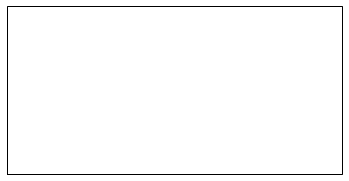

In [9]:
plt.axes(projection=ccrs.PlateCarree())

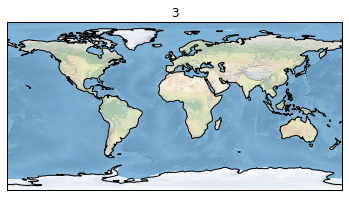

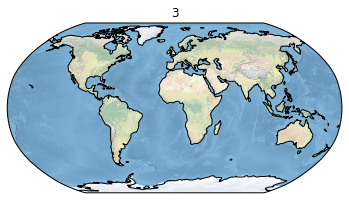

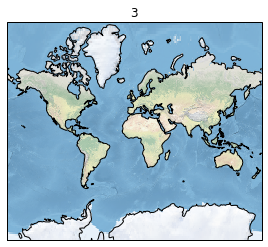

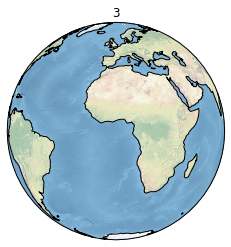

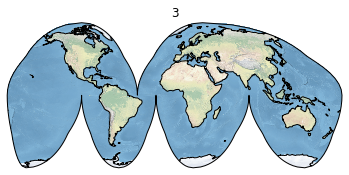

In [11]:


projections = [ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Mercator(),
               ccrs.Orthographic(),
               ccrs.InterruptedGoodeHomolosine()
              ]


for proj in projections:
    plt.figure()
    ax = plt.axes(projection=proj)
    ax.stock_img()
    ax.coastlines()
    ax.set_title(f'3')



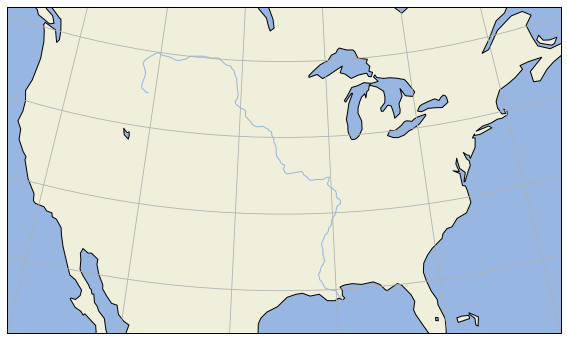

In [13]:


import cartopy.feature as cfeature
import numpy as np

central_lat = 37.5
central_lon = -96
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_lon, central_lat))
ax.set_extent(extent)

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.gridlines()



In [14]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import scipy as sp
from mpl_toolkits.basemap import Basemap
from datetime import datetime
import os
from os.path import abspath
plt.style.use("seaborn")


La siguiente función ayuda a leer un archivo netcdf

In [14]:
from sklearn.utils import check_random_state

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    return data

Función para obtener realizar un análisis espectral

In [3]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1/len(serie))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

# Cargando los datos

In [17]:
# carpeta = "D:\Google Drive\Documents\Semestre 10\Analisis de datos ambientales\Tarea 1\Dataset"
# rutas = [abspath(element.path) for element in os.scandir(carpeta) if abspath(element.path)[-2:]=="nc"]
# for i in range(0,len(rutas)):
#     data=reading_netcdf(rutas[i])
#     if i==0:
#         ssh=data.variables["ssha"][:,:,:]
#     else:
#         ssh2=data.variables["ssha"][:,:,:]
#         ssh=np.concatenate((ssh,ssh2))
#     lat=data.variables["lat"][:]
#     lon=data.variables["lon"][:]

In [31]:
ruta= "D:\Google Drive\Documents\Semestre 10\Analisis de datos ambientales\Tarea 1\Dataset\sst.mon.mean.nc"
data=reading_netcdf(ruta)
lon=data["lon"][:]
lat=data["lat"][:]
sst=data["sst"][:]
time=data["time"][:]

lat (180,) degrees_north
lon (360,) degrees_east
time (2028,) days since 1891-1-1 00:00:00
sst (2028, 180, 360) degC




# Definiendo la serie temporal

A continuación se preparan las series de datos espacio-temporales a usar y se determina la serie temporal final que será evaluada a través de el análisis espectral

In [40]:
lat_max = 7.5
lat_min = 0.5
lon_max = 283.5
lon_min = 276.5

ind_lat = np.where((lat<=lat_max) & (lat>=lat_min))[0]
ind_lon = np.where((lon<=lon_max) & (lon>=lon_min))[0]

In [45]:
x,y=np.meshgrid(lon[ind_lon],lat[ind_lat])
plt.figure()
plt.contourf(x,y,sst[0,ind_lat[0]:ind_lat[-1]+1,ind_lon[0]:ind_lon[-1]+1],cmap="plasma")
plt.colorbar(orientation="horizontal")

La serie temporal que se determinará para la región del océano pacífico colombiano será el promedio longitudinal y latitudinal de los datos obtenidos

In [21]:
sst_lat=np.mean(sst[:,ind_lat,:],axis=1)
sst_mean=np.mean(sst_lat[:,ind_lon],axis=1)

sst_mean_anm=sst_mean-np.mean(sst_mean)

## Graficando la serie

In [22]:
%matplotlib qt
plt.figure()
plt.suptitle("Serie de datos promediados espacialmente")
plt.subplot(121)
plt.plot(sst_mean,c="darkcyan")
plt.ylabel("slm [m]")

plt.subplot(122)
plt.plot(sst_mean_anm,c="navy")
plt.ylabel("slm [m]")
# plt.savefig(".\Graficas\Series.jpg",dpi=800,box_inches="tight",pad_inches=0)

Text(0, 0.5, 'slm [m]')

# Realizando el análisis espectral

In [23]:
sst_fourier,sst_freq_pos,sst_potencias,sst_periodos,sst_freq,=T_fourier(sst_mean_anm)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


## Graficando el espectro de potencias

In [24]:
plt.figure()
plt.plot(sst_periodos[sst_freq_pos],sst_potencias[sst_freq_pos],'-o',c="firebrick")
# plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.savefig(".\Graficas\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

## Seleccionando la banda de interés

Puede notarse que el intervalo de períodos que más regula la variable de nivel medio del mar está comprendido entre ... y ... días.

In [28]:
freq_fil=np.copy(sst_fourier)
freq_fil[np.where(np.abs(1/sst_freq)>5)]=0

Pot_fil=np.abs(freq_fil*1/len(freq_fil))**2

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [30]:
plt.figure()
plt.title("Banda espectral de interés")
plt.plot(sst_periodos[sst_freq_pos],Pot_fil[sst_freq_pos],'-o')
# plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.axvline(2,0,1,ls='--',c="k")
plt.axvline(5,0,1,ls='--',c="k")
plt.xlim(0,24)
plt.savefig(".\Graficas\Banda espectral interes.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Mapa de varianza

In [63]:
var_banda.shape

(8, 8)

In [141]:
sst_var=sum(Pot_fil)
# pearson=np.zeros((len(lat)),len(lon))
# pearson_banda=np.zeros()
var=np.zeros((len(lat),len(lon)))
var_banda=np.zeros((len(lat),len(lon)))
var_porcentaje=np.zeros((len(lat),len(lon)))
# matriz_inversa=np.zeros((len(time)),len(lat),len(lon))

for i in range(len(lat)):
    for j in range(len(lon)):
#         sst_array=np.array(sst)
        point=sst[:,i,j]
        point_anm=point-np.mean(point)
        tf_p,fp_p,pot_p,per_p,f_p=T_fourier(point_anm)
        pos_banda=np.where((np.abs(per_p)>18) & (np.abs(per_p)<96))[0]
#         print(len(pos_banda))
        var_banda[i,j]=sum(pot_p[pos_banda])
        var[i,j]=np.var(point)
        var_porcentaje[i,j]=(sum(pot_p[pos_banda])/np.var(point))*100
        
#         pearson[i,j]=pearsonr(serie,slm[:,i,j])[0]
#         spearman[i,j]=spearmanr(serie,slm[:,i,j])[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Warning: converting a masked element to nan.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Warning: converting a masked element to nan.


In [86]:
vb=var_banda[ind_lat[0]:ind_lat[-1]+1,ind_lon[0]:ind_lon[-1]+1]

In [140]:
fig=plt.figure(figsize=(20,16))
ax=fig.add_subplot(111)

N,S,W,E=90,-90,260,0

m=Basemap(llcrnrlat=lat[-1],urcrnrlat=lat[0],
            llcrnrlon=lon[0],urcrnrlon=lon[-1],resolution='l',area_thresh=10000)
x,y=m(*np.meshgrid(lon,lat))
cs=m.contourf(x,y,var_porcentaje,levels=np.arange(0,0.65,0.05),cmap="seismic")
cbar = m.colorbar(location='bottom',pad='10%')
m.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0],size=11,linewidth=0.1)
m.drawmeridians(np.arange(0,360,20),labels=[0,1,0,1],size=11, linewidth=0.1)
m.drawcoastlines()
# m.drawmapboundary()

MaskError: Mask and data not compatible: data size is 1, mask size is 64800.

In [117]:
# lat_max = 7.5
# lat_min = 0.5
# lon_max = 283.5
# lon_min = 276.5

# fig=plt.figure(figsize=(20,16))
# ax=fig.add_subplot(111)

# N,S,W,E=8,0,285,275

# m=Basemap(E,S,W,N,resolution='l',area_thresh=10000)
# x,y=m(*np.meshgrid(lon[ind_lon],lat[ind_lat]))
# cs=m.contourf(x,y,vb,cmap="seismic")
# cbar = m.colorbar(location='bottom',pad='10%')
# m.drawparallels(np.arange(0,8,2),labels=[1,0,0,0],size=11,linewidth=0.1)
# m.drawmeridians(np.arange(0,360,20),labels=[0,1,0,1],size=11, linewidth=0.1)
# m.drawcoastlines()
# m.drawmapboundary()